### Intel Optimised PyTorch (IPEX) running on Intel Developers Cloud

In [8]:
# # Required packages, install if not installed (assume PyTorch* and Intel® Extension for PyTorch* is already present)
# import sys
# !echo "Installation in progress..."
# !conda install -y --quiet  --prefix {sys.prefix} -c conda-forge \
#     accelerate==0.23.0 \
#     validators==0.22.0 \
#     diffusers==0.18.2 \
#     transformers==4.32.1 \
#     pillow \
#     ipywidgets \
#     ipython > /dev/null && echo "Installation successful" || echo "Installation failed"
# import sys
# !{sys.executable} -m pip install invisible-watermark --user > /dev/null 2>&1
# !{sys.executable} -m pip install transformers huggingface-hub --user > /dev/null 2>&1
# !echo "Installation complete..."

In [13]:
from io import BytesIO
import os
import random
import time
import warnings
from pathlib import Path
from typing import List, Dict, Tuple

# Suppress warnings for a cleaner output.
warnings.filterwarnings("ignore")

import requests
import torch
import torch.nn as nn
import intel_extension_for_pytorch as ipex  # Used for optimizing PyTorch models
from PIL import Image

from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler

In [14]:
class Text2ImgModel:
    """
    Text2ImgModel is a class for generating images based on text prompts using a pretrained model.

    Attributes:
    - device: The device to run the model on. Default to "xpu" - Intel dGPUs.
    - pipeline: The loaded model pipeline.
    - data_type: The data type to use in the model.
    """

    def __init__(
        self,
        model_id_or_path: str,
        device: str = "xpu",
        torch_dtype: torch.dtype = torch.bfloat16,
        optimize: bool = True,
        enable_scheduler: bool = False,
        warmup: bool = False,
    ) -> None:
        """
        The initializer for Text2ImgModel class.

        Parameters:
        - model_id_or_path: The identifier or path of the pretrained model.
        - device: The device to run the model on. Default is "xpu".
        - torch_dtype: The data type to use in the model. Default is torch.bfloat16.
        - optimize: Whether to optimize the model after loading. Default is True.
        """

        self.device = device
        self.pipeline = self._load_pipeline(
            model_id_or_path, torch_dtype, enable_scheduler
        )
        self.data_type = torch_dtype
        if optimize:
            start_time = time.time()
            #print("Optimizing the model...")
            self.optimize_pipeline()
            #print(
            #    "Optimization completed in {:.2f} seconds.".format(
            #        time.time() - start_time
            #    )
            #)
        if warmup:
            self.warmup_model()

    def _load_pipeline(
        self,
        model_id_or_path: str,
        torch_dtype: torch.dtype,
        enable_scheduler: bool,

    ) -> DiffusionPipeline:
        """
        Loads the pretrained model and prepares it for inference.

        Parameters:
        - model_id_or_path: The identifier or path of the pretrained model.
        - torch_dtype: The data type to use in the model.

        Returns:
        - pipeline: The loaded model pipeline.
        """

        print("Loading the model...")
        model_path = Path(f"/home/common/data/Big_Data/GenAI/{model_id_or_path}")  
        
        if model_path.exists():
            #print(f"Loading the model from {model_path}...")
            load_path = model_path
        else:
            print("Using the default path for models...")
            load_path = model_id_or_path

        pipeline = DiffusionPipeline.from_pretrained(
            load_path,
            torch_dtype=torch_dtype,
            use_safetensors=True,
            variant="fp16",
        )
        if enable_scheduler:
            pipeline.scheduler = DPMSolverMultistepScheduler.from_config(
                pipeline.scheduler.config
            )
        if not model_path.exists():
            try:
                print(f"Attempting to save the model to {model_path}...")
                pipeline.save_pretrained(f"{model_path}")
                print("Model saved.")
            except Exception as e:
                print(f"An error occurred while saving the model: {e}. Proceeding without saving.")
        pipeline = pipeline.to(self.device)
        #print("Model loaded.")
        return pipeline

    def _optimize_pipeline(self, pipeline: DiffusionPipeline) -> DiffusionPipeline:
        """
        Optimizes the model for inference using ipex.

        Parameters:
        - pipeline: The model pipeline to be optimized.

        Returns:
        - pipeline: The optimized model pipeline.
        """

        for attr in dir(pipeline):
            try:
                if isinstance(getattr(pipeline, attr), nn.Module):
                    setattr(
                        pipeline,
                        attr,
                        ipex.optimize(
                            getattr(pipeline, attr).eval(),
                            dtype=pipeline.text_encoder.dtype,
                            inplace=True,
                        ),
                    )
            except AttributeError:
                pass
        return pipeline

    def warmup_model(self):
        """
        Warms up the model by generating a sample image.
        """
        print("Setting up model...")
        start_time = time.time()
        self.generate_images(
            prompt="A beautiful sunset over the mountains",
            num_images=1,
            save_path=".tmp",
        )
        print(
            "Model is set up and ready! Warm-up completed in {:.2f} seconds.".format(
                time.time() - start_time
            )
        )

    def optimize_pipeline(self) -> None:
        """
        Optimizes the current model pipeline.
        """

        self.pipeline = self._optimize_pipeline(self.pipeline)

    def generate_images(
        self,
        prompt: str,
        num_inference_steps: int = 50,
        num_images: int = 5,
        save_path: str = "output",
    ) -> List[Image.Image]:
        """
        Generates images based on the given prompt and saves them to disk.

        Parameters:
        - prompt: The text prompt to generate images from.
        - num_inference_steps: Number of noise removal steps.
        - num_images: The number of images to generate. Default is 5.
        - save_path: The directory to save the generated images in. Default is "output".

        Returns:
        - images: A list of the generated images.
        """

        images = []
        for i in range(num_images):
            with torch.xpu.amp.autocast(
                enabled=True if self.data_type != torch.float32 else False,
                dtype=self.data_type,
            ):
                image = self.pipeline(
                    prompt=prompt,
                    num_inference_steps=num_inference_steps,
                    #negative_prompt=negative_prompt,
                ).images[0]
                if not os.path.exists(save_path):
                    try:
                        os.makedirs(save_path)
                    except OSError as e:
                        print("Failed to create directory", save_path, "due to", str(e))
                        raise
            output_image_path = os.path.join(
                save_path,
                f"{'_'.join(prompt.split()[:3])}_{i}_{sum(ord(c) for c in prompt) % 10000}.png",
            )
            image.save(output_image_path)
            images.append(image)
        return images



Once generated, images will be saved to `./output` dir, please wait...
Loading the model...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Complete generating 1 images in './output' in 3.64 seconds.


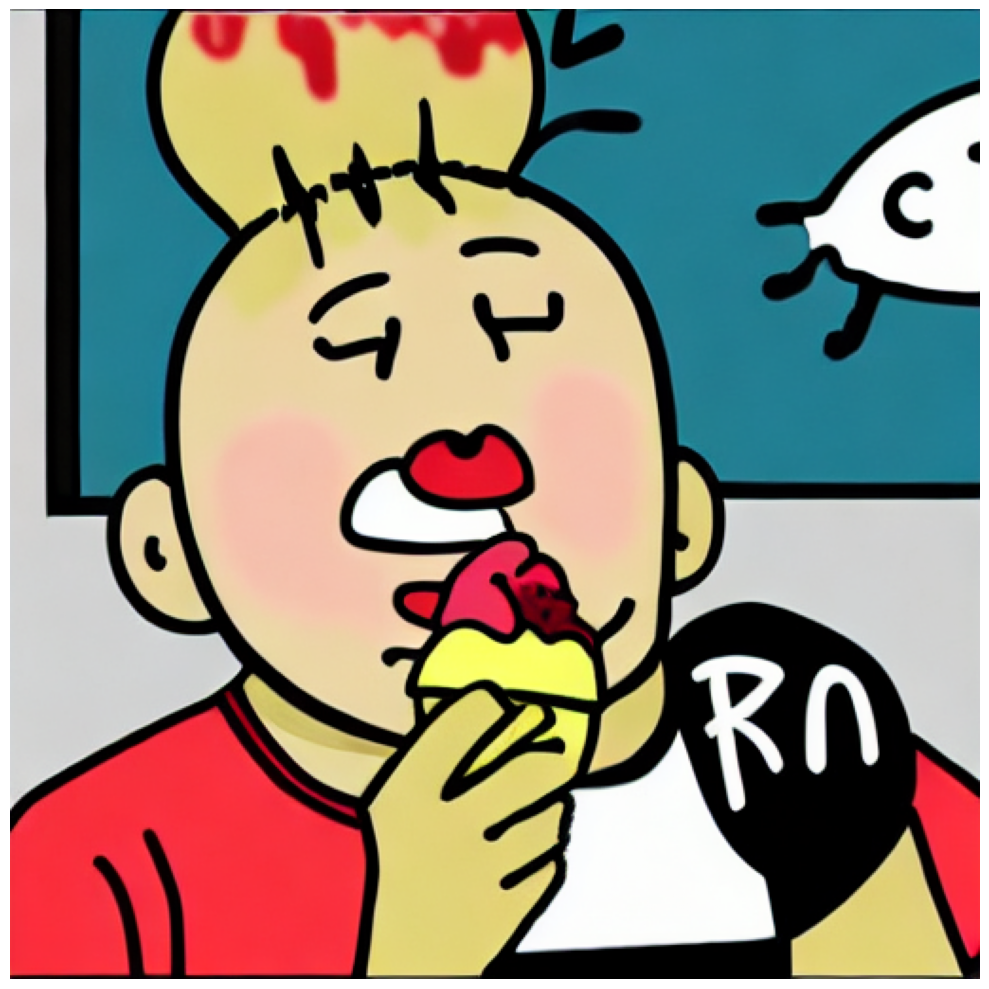

Time taken by Intel Optimised Stable Diffusion: 5.838752031326294


In [22]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mp_img

# Hardcoded values
model_id = "CompVis/stable-diffusion-v1-4"
prompt = "shin-chan eating icecream, cartoon, 8k, ultra-detailed"
num_images = 1

def generate_and_display_images():
  """Generates images using the hardcoded prompt and displays them."""

  print("\nOnce generated, images will be saved to `./output` dir, please wait...")

  # Load the model (assuming Text2ImgModel is defined elsewhere)
  model = Text2ImgModel(model_id, device="xpu")

  # Define num_images again within the function for proper scope
  num_images = 1  # Use the hardcoded value here

  # Generate images
  try:
    start_time = time.time()
    model.generate_images(
        prompt,
        num_images=num_images,
        save_path="./output",
    )
    print(f"Complete generating {num_images} images in './output' in {time.time() - start_time:.2f} seconds.")

    # Display generated images
    image_files = [f for f in os.listdir("./output") if f.endswith((".png", ".jpg"))]
    num_images = len(image_files)  # Update num_images based on actual generated images
    num_columns = int(np.ceil(np.sqrt(num_images)))
    num_rows = int(np.ceil(num_images / num_columns))
    fig, axs = plt.subplots(num_rows, num_columns, figsize=(10 * num_columns / num_columns, 10 * num_rows / num_rows))
    if num_images == 1:
      axs = np.array([[axs]])
    elif num_columns == 1 or num_rows == 1:
      axs = np.array([axs])
    for ax, image_file in zip(axs.ravel(), image_files):
      img = mp_img.imread(os.path.join("./output", image_file))
      ax.imshow(img)
      ax.axis("off")  # Hide axes
    for ax in axs.ravel()[num_images:]:
      ax.axis("off")
    plt.tight_layout()
    plt.show()

  except KeyboardInterrupt:
    print("\nUser interrupted image generation...")
  except Exception as e:
    print(f"An error occurred: {e}")

# Run the generation and display function
start = time.time()
generate_and_display_images()
end = time.time()
intel_sd_time = end-start
print(f"Time taken by Intel Optimised Stable Diffusion: {intel_sd_time}")

<!--#### Reference and Guidelines for Models Used in This Notebook

##### CompVis/stable-diffusion-v1-4
- **Model card:** [CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4)
- **License:** CreativeML OpenRAIL M license
- **Reference:**
    ```bibtex
    @InProceedings{Rombach_2022_CVPR,
        author    = {Rombach, Robin and Blattmann, Andreas and Lorenz, Dominik and Esser, Patrick and Ommer, Bj\"orn},
        title     = {High-Resolution Image Synthesis With Latent Diffusion Models},
        booktitle = {Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR)},
        month     = {June},
        year      = {2022},
        pages     = {10684-10695}
    }
    ```

##### stabilityai/stable-diffusion-2
- **Model card:** [stabilityai/stable-diffusion-2](https://huggingface.co/stabilityai/stable-diffusion-2)
- **License:** CreativeML Open RAIL++-M License
- **Reference:**
    ```bibtex
    @InProceedings{Rombach_2022_CVPR,
        author    = {Rombach, Robin and Blattmann, Andreas and Lorenz, Dominik and Esser, Patrick and Ommer, Bj\"orn},
        title     = {High-Resolution Image Synthesis With Latent Diffusion Models},
        booktitle = {Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR)},
        month     = {June},
        year      = {2022},
        pages     = {10684-10695}
    }
    ```

##### Disclaimer for Using Stable Diffusion Models

The stable diffusion models provided here are powerful tools for high-resolution image synthesis, including text-to-image and image-to-image transformations. While they are designed to produce high-quality results, users should be aware of potential limitations:

- **Quality Variation:** The quality of generated images may vary based on the complexity of the input text or image, and the alignment with the model's training data.
- **Licensing and Usage Constraints:** Please carefully review the licensing information associated with each model to ensure compliance with all terms and conditions.
- **Ethical Considerations:** Consider the ethical implications of the generated content, especially in contexts that may involve sensitive or controversial subjects.

For detailed information on each model's capabilities, limitations, and best practices, please refer to the respective model cards and associated publications linked below.